In [1]:
import pandas
import seaborn

import cltrier_lib

import twon_agents

In [3]:
SEED: int = 1
DATA_PATH: str = "../../../data"

In [4]:
post_ids: pandas.DataFrame = pandas.read_csv(
    f"{DATA_PATH}/interim/twitter.german.posts.csv", index_col=0
)[["id"]]
post_ids

,id
0,1625772644120334336
1,1624882807259467777
2,1649799899679014915
3,1612788201877282817
4,1647187822753861632
...,...
863,1641705169422303232
864,1616759620143292417
865,1610607783254298624
866,1659447745755721734


In [7]:
replies: pandas.DataFrame = (
    pandas.read_csv(
        f"{DATA_PATH}/raw/twitter.german/GermanyReplies2023.csv", index_col=0
    )
    .pipe(twon_agents.data.filter_tweets, remove_w_mentions=False)
    .merge(post_ids, left_on="conversation_id", right_on="id")
    .rename(columns={"id_x": "id"})
)
replies

,id,author_id,conversation_id,text,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.bookmark_count,public_metrics.impression_count,created_at,username,in_reply_to_user_id,id_y
0,1626210251342053377,1498678918374735878,1626182469757140993,@n_roettgen Kämpfen für unsere Freiheit? So wi...,0,0,0,0,0,7,2023-02-16T13:21:52.000Z,n_roettgen,1040160799208161280,1626182469757140993
1,1626210339351150592,1585985488577503243,1626182469757140993,@n_roettgen Weil auch andere Länder Rückzieher...,0,0,0,0,0,10,2023-02-16T13:22:13.000Z,n_roettgen,1040160799208161280,1626182469757140993
2,1615837811294507008,1577540347437129728,1615836681713897472,@Einschlag22's account is temporarily unavaila...,0,0,0,0,0,26,2023-01-18T22:25:29.000Z,n_roettgen,1040160799208161280,1615836681713897472
3,1626213768190386178,1495081753022799875,1626182469757140993,@n_roettgen Warum wollen die anderen Länder wo...,1,0,8,0,0,89,2023-02-16T13:35:50.000Z,n_roettgen,1040160799208161280,1626182469757140993
4,1626211962123059200,1174913102728454144,1626182469757140993,@n_roettgen Die Ukraine kämpft für sich selber...,0,0,0,0,0,1,2023-02-16T13:28:39.000Z,n_roettgen,1040160799208161280,1626182469757140993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184638,1657432545997332481,1451289309424803840,1657421695181897728,@AnAudretsch @_FriedrichMerz Sagt ein GRÜNER 🤣,0,0,2,0,0,8,2023-05-13T17:08:07.000Z,AnAudretsch,995519538,1657421695181897728
184639,1657431761331134464,212688037,1657421695181897728,@AnAudretsch @_FriedrichMerz Andreas Du sprich...,1,0,2,0,0,16,2023-05-13T17:05:00.000Z,AnAudretsch,995519538,1657421695181897728
184640,1657491488870105089,3373809729,1657421695181897728,@AnAudretsch @_FriedrichMerz Sie Linkspopulist...,0,0,0,0,0,21,2023-05-13T21:02:20.000Z,AnAudretsch,995519538,1657421695181897728
184641,1657455359198474242,1266617819132841984,1657421695181897728,@AnAudretsch @_FriedrichMerz Das sie aktuell ü...,0,0,1,0,0,44,2023-05-13T18:38:46.000Z,AnAudretsch,995519538,1657421695181897728


In [5]:
# calculate the distribution of user activity (number of posts)
user_activity_dist: pandas.Series = (
    replies["author_id"]
    .value_counts()
    .describe(
        percentiles=[
            0.25,
            0.5,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95,
            0.96,
            0.97,
            0.98,
            0.99,
            0.995,
        ]
    )
)
user_activity_dist

count    38188.000000
mean         2.401435
std          3.005037
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
80%          3.000000
85%          4.000000
90%          5.000000
95%          7.000000
96%          8.000000
97%         10.000000
98%         11.000000
99%         15.000000
99.5%       19.000000
max        116.000000
Name: count, dtype: float64

In [6]:
selected_percentile: str = "99%"

sampled_replies: pandas.DataFrame = (
    replies[
        # select only the 40% most active users
        replies["author_id"].isin(
            list(
                (
                    replies["author_id"].value_counts()
                    > user_activity_dist.loc[selected_percentile]
                )
                .pipe(lambda _s: _s[_s])
                .index
            )
        )
    ]
    .groupby("author_id")
    # sample by number of least active 40%' user posts
    .sample(n=int(user_activity_dist.loc[selected_percentile]), random_state=SEED)
)

len(sampled_replies), len(sampled_replies["author_id"].unique())

(5220, 348)

In [7]:
sampled_replies

,id,author_id,conversation_id,text,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.bookmark_count,public_metrics.impression_count,created_at,username,in_reply_to_user_id,id_y
60884,1617114281132314624,15891726,1616701560431542272,@RKiesewetter Wussten das die CDU Verteidigung...,0,0,0,0,0,1,2023-01-22T10:57:43.000Z,RKiesewetter,42698498,1616701560431542272
69622,1620308520087199744,15891726,1620171503957581825,@StBrandner Da es keinen Staatsfunk gibt: Nein.,0,0,0,0,0,72,2023-01-31T06:30:29.000Z,StBrandner,713361366858481664,1620171503957581825
40706,1649890068067151878,15891726,1649820541207863300,"@f_schaeffler Steht da auch drinne, dass die D...",0,0,0,0,0,9,2023-04-22T21:37:00.000Z,f_schaeffler,18189342,1649820541207863300
67262,1610903010426908673,15891726,1610260317262471171,@katjadler Leute die Begriffe wie „kulturelle ...,0,0,0,0,0,21,2023-01-05T07:36:21.000Z,katjadler,712941191,1610260317262471171
69879,1657718828485206016,15891726,1657692554706534401,@StBrandner Oh doch. Zum Beispiel könnte eine ...,0,0,1,0,0,14,2023-05-14T12:05:42.000Z,StBrandner,713361366858481664,1657692554706534401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51732,1651852920076267520,1642154882693038081,1651619903105912833,@nyke_slawik Nein herrlich! Eventuell wählt di...,0,0,0,0,0,5,2023-04-28T07:36:40.000Z,nyke_slawik,3002271760,1651619903105912833
72765,1656330522694504450,1642154882693038081,1656250439224946688,@Tino_Chrupalla @RusBotschaft Das ZDF verstrah...,0,0,0,0,0,8,2023-05-10T16:09:04.000Z,Tino_Chrupalla,797137333820784640,1656250439224946688
62180,1660735964837183489,1642154882693038081,1660674403879755777,@GoeringEckardt @hartaberfair @DasErste Mit so...,0,0,0,0,0,25,2023-05-22T19:54:43.000Z,GoeringEckardt,626287930,1660674403879755777
72627,1645876119126810624,1642154882693038081,1645732899742703616,@Tino_Chrupalla Was zum Teufel sind eigentlich...,0,1,0,0,0,9,2023-04-11T19:47:00.000Z,Tino_Chrupalla,797137333820784640,1645732899742703616


In [8]:
(
    sampled_replies
    # remove linebreaks and mentions at beginning
    .assign(
        text=(
            sampled_replies["text"]
            .replace(r"\n", " ", regex=True)
            .replace(r"^@(\w){1,15}\s?(@(\w){1,15})*", "", regex=True)
        )
    )[["id", "author_id", "conversation_id", "created_at", "text"]].to_csv(
        f"{DATA_PATH}/interim/twitter.german.replies.csv"
    )
)

In [9]:
classified_data = pandas.json_normalize(
    [
        sample.model_dump()
        for sample in cltrier_lib.classify.Pipeline()(
            list(sampled_replies["text"]), threshold=0.0
        )
    ]
)
classified_data

,sample,results.topics.arts_&_culture,results.topics.business_&_entrepreneurs,results.topics.celebrity_&_pop_culture,results.topics.diaries_&_daily_life,results.topics.family,results.topics.fashion_&_style,results.topics.film_tv_&_video,results.topics.fitness_&_health,results.topics.food_&_dining,...,results.emotions.trust,results.sentiment.negative,results.sentiment.neutral,results.sentiment.positive,results.irony.non_irony,results.irony.irony,results.offensive.non-offensive,results.offensive.offensive,results.hate.NOT-HATE,results.hate.HATE
0,@RKiesewetter Wussten das die CDU Verteidigung...,0.010403,0.004250,0.017381,0.068277,0.001605,0.000734,0.011765,0.001554,0.000840,...,0.030379,0.270784,0.773874,0.374926,0.810347,0.285108,0.710429,0.309836,0.931027,0.080776
1,@StBrandner Da es keinen Staatsfunk gibt: Nein.,0.022527,0.006241,0.175455,0.079630,0.001431,0.005069,0.109173,0.001740,0.000917,...,0.011219,0.262889,0.737343,0.396053,0.827131,0.316757,0.713729,0.307276,0.920231,0.082769
2,"@f_schaeffler Steht da auch drinne, dass die D...",0.096684,0.008564,0.033465,0.211034,0.004652,0.003375,0.010797,0.003691,0.001490,...,0.026807,0.238850,0.750003,0.450912,0.885061,0.194130,0.739730,0.279449,0.948221,0.059228
3,@katjadler Leute die Begriffe wie „kulturelle ...,0.043447,0.003945,0.159271,0.141028,0.011590,0.001960,0.105020,0.004714,0.001554,...,0.008653,0.399478,0.719105,0.293288,0.793308,0.310786,0.665345,0.350036,0.886828,0.108899
4,@StBrandner Oh doch. Zum Beispiel könnte eine ...,0.055064,0.006693,0.132551,0.016529,0.002345,0.005889,0.022203,0.004730,0.001238,...,0.039536,0.264005,0.747439,0.410508,0.726433,0.366130,0.688613,0.331351,0.945741,0.061119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5215,@nyke_slawik Nein herrlich! Eventuell wählt di...,0.013116,0.009059,0.028200,0.042101,0.001510,0.001874,0.012149,0.001188,0.000672,...,0.058914,0.162306,0.727314,0.622772,0.816428,0.267064,0.744944,0.269698,0.955697,0.044004
5216,@Tino_Chrupalla @RusBotschaft Das ZDF verstrah...,0.077125,0.015609,0.017731,0.078705,0.001460,0.004026,0.027874,0.001110,0.001389,...,0.028390,0.108666,0.594224,0.832509,0.680777,0.416570,0.710064,0.295652,0.908470,0.098297
5217,@GoeringEckardt @hartaberfair @DasErste Mit so...,0.038423,0.008604,0.027372,0.292372,0.002446,0.003985,0.009152,0.002418,0.003118,...,0.045368,0.175892,0.761234,0.533312,0.820887,0.244813,0.748947,0.271437,0.950803,0.055427
5218,@Tino_Chrupalla Was zum Teufel sind eigentlich...,0.102737,0.144527,0.012784,0.213372,0.004211,0.008295,0.020930,0.001312,0.012716,...,0.025128,0.277564,0.864931,0.253881,0.860845,0.226521,0.744517,0.269264,0.941371,0.063817


<Axes: xlabel='value', ylabel='variable'>

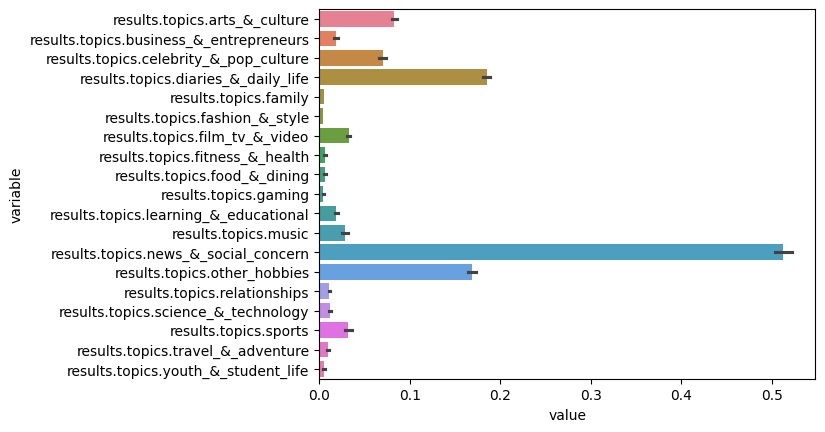

In [10]:
seaborn.barplot(
    classified_data.filter(like=".topics.").melt(),
    x="value",
    y="variable",
    hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

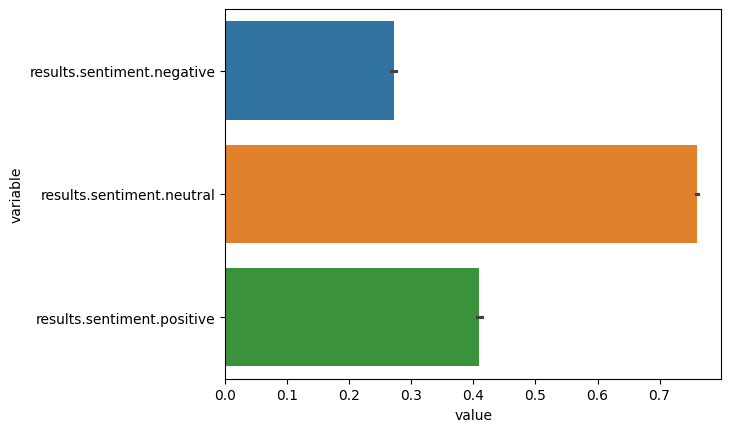

In [11]:
seaborn.barplot(
    classified_data.filter(like=".sentiment.").melt(),
    x="value",
    y="variable",
    hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

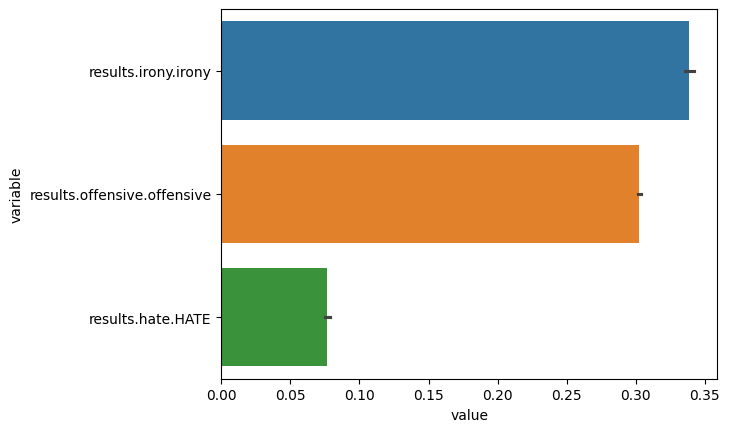

In [12]:
seaborn.barplot(
    classified_data.filter(regex="irony\.irony|offensive\.offensive|hate\.HATE").melt(),
    x="value",
    y="variable",
    hue="variable",
)